# Trace Clustering


In [1]:
import segmentation as sg
import pm4py as pm
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer
from pm4py.objects.log.util import dataframe_utils
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
path = os.path.join(os.getcwd(),'data', 'mimicel.csv')
df = pd.read_csv(path)

'''
xes = pm.read_xes(path)
df = pm.convert_to_dataframe(xes)
'''

'\nxes = pm.read_xes(path)\ndf = pm.convert_to_dataframe(xes)\n'

## Understanding Data

In [3]:
df.info(verbose=True)
# subject_id as CaseId (consistency wit sepsis benchmark)
# timestamps and activities
# gender or race? (Instead of Age)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7568824 entries, 0 to 7568823
Data columns (total 31 columns):
 #   Column             Dtype  
---  ------             -----  
 0   stay_id            int64  
 1   subject_id         int64  
 2   hadm_id            float64
 3   timestamps         object 
 4   activity           object 
 5   gender             object 
 6   race               object 
 7   arrival_transport  object 
 8   disposition        object 
 9   seq_num            float64
 10  icd_code           object 
 11  icd_version        float64
 12  icd_title          object 
 13  temperature        float64
 14  heartrate          float64
 15  resprate           float64
 16  o2sat              float64
 17  sbp                float64
 18  dbp                float64
 19  pain               object 
 20  acuity             float64
 21  chiefcomplaint     object 
 22  rhythm             object 
 23  name               object 
 24  gsn                float64
 25  ndc               

In [4]:
df = df.rename(columns={
    'subject_id': 'case:concept:name',      
    'activity': 'concept:name',               
    'timestamps': 'time:timestamp'           
})

In [5]:
df.isnull().sum()

stay_id                    0
case:concept:name          0
hadm_id              3015236
time:timestamp             0
concept:name               0
gender               7143796
race                 7143796
arrival_transport    7143796
disposition          6668747
seq_num              6669845
icd_code             6669845
icd_version          6669845
icd_title            6669845
temperature          6259715
heartrate            5801023
resprate             5822404
o2sat                5864053
sbp                  5812828
dbp                  5813628
pain                 6131688
acuity               7150772
chiefcomplaint       7143817
rhythm               7515079
name                 3173867
gsn                  3206271
ndc                  4615706
etc_rn               4615706
etccode              4627281
etcdescription       4627281
med_rn               6126985
gsn_rn               6126985
dtype: int64

In [6]:
df.head()

,stay_id,case:concept:name,hadm_id,time:timestamp,concept:name,gender,race,arrival_transport,disposition,seq_num,...,chiefcomplaint,rhythm,name,gsn,ndc,etc_rn,etccode,etcdescription,med_rn,gsn_rn
0,30000012,11714491,21562392.0,2126-02-14 20:22:00,Vital sign check,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30000012,11714491,21562392.0,2126-02-14 20:22:00,Enter the ED,F,WHITE,AMBULANCE,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30000012,11714491,21562392.0,2126-02-14 20:22:01,Triage in the ED,NaN,NaN,NaN,NaN,NaN,...,CHANGE IN MENTAL STATUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30000012,11714491,21562392.0,2126-02-14 22:21:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,rifaximin,66295.0,5.486862e+10,1.0,5844.0,Rifamycins and Related Derivative Antibiotics,NaN,NaN
4,30000012,11714491,21562392.0,2126-02-14 22:21:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"multivitamin,tx-minerals",2510.0,1.026707e+10,1.0,704.0,Multivitamin and Mineral Combinations,NaN,NaN


In [7]:
df['gender'].value_counts()

gender
F    229868
M    195160
Name: count, dtype: int64

In [8]:
non_null_cols = df.columns[~df.isna().any()]
print("모든 행에 NaN이 없는 열들:", list(non_null_cols))

모든 행에 NaN이 없는 열들: ['stay_id', 'case:concept:name', 'time:timestamp', 'concept:name']


In [9]:
df['gender'] = df.groupby('case:concept:name')['gender'].transform(lambda x: x.ffill().bfill())

In [10]:
df.head()

,stay_id,case:concept:name,hadm_id,time:timestamp,concept:name,gender,race,arrival_transport,disposition,seq_num,...,chiefcomplaint,rhythm,name,gsn,ndc,etc_rn,etccode,etcdescription,med_rn,gsn_rn
0,30000012,11714491,21562392.0,2126-02-14 20:22:00,Vital sign check,F,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30000012,11714491,21562392.0,2126-02-14 20:22:00,Enter the ED,F,WHITE,AMBULANCE,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30000012,11714491,21562392.0,2126-02-14 20:22:01,Triage in the ED,F,NaN,NaN,NaN,NaN,...,CHANGE IN MENTAL STATUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30000012,11714491,21562392.0,2126-02-14 22:21:00,Medicine reconciliation,F,NaN,NaN,NaN,NaN,...,NaN,NaN,rifaximin,66295.0,5.486862e+10,1.0,5844.0,Rifamycins and Related Derivative Antibiotics,NaN,NaN
4,30000012,11714491,21562392.0,2126-02-14 22:21:00,Medicine reconciliation,F,NaN,NaN,NaN,NaN,...,NaN,NaN,"multivitamin,tx-minerals",2510.0,1.026707e+10,1.0,704.0,Multivitamin and Mineral Combinations,NaN,NaN


In [11]:
df[df['gender'] == 'M']

,stay_id,case:concept:name,hadm_id,time:timestamp,concept:name,gender,race,arrival_transport,disposition,seq_num,...,chiefcomplaint,rhythm,name,gsn,ndc,etc_rn,etccode,etcdescription,med_rn,gsn_rn
23,30000017,14230614,NaN,2185-06-18 11:51:00,Enter the ED,M,BLACK/AFRICAN AMERICAN,WALK IN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,30000017,14230614,NaN,2185-06-18 11:51:01,Triage in the ED,M,NaN,NaN,NaN,NaN,...,"ETOH, Unable to ambulate",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,30000017,14230614,NaN,2185-06-18 14:48:00,Medicine dispensations,M,NaN,NaN,NaN,NaN,...,NaN,NaN,Multivitamins,2532.0,NaN,NaN,NaN,NaN,1.0,3.0
26,30000017,14230614,NaN,2185-06-18 14:48:00,Medicine dispensations,M,NaN,NaN,NaN,NaN,...,NaN,NaN,Multivitamins,2475.0,NaN,NaN,NaN,NaN,1.0,1.0
27,30000017,14230614,NaN,2185-06-18 14:48:00,Medicine dispensations,M,NaN,NaN,NaN,NaN,...,NaN,NaN,Thiamine,16981.0,NaN,NaN,NaN,NaN,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7568815,39999964,16479007,29821286.0,2130-06-06 13:25:00,Medicine reconciliation,M,NaN,NaN,NaN,NaN,...,NaN,NaN,clonazepam,4561.0,1.054403e+10,3.0,6615.0,Benzodiazepines,NaN,NaN
7568816,39999964,16479007,29821286.0,2130-06-06 13:25:00,Medicine reconciliation,M,NaN,NaN,NaN,NaN,...,NaN,NaN,clonazepam,4561.0,1.054403e+10,2.0,2683.0,Anticonvulsant - Benzodiazepines,NaN,NaN
7568817,39999964,16479007,29821286.0,2130-06-06 14:42:00,Vital sign check,M,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7568818,39999964,16479007,29821286.0,2130-06-06 18:27:00,Discharge from the ED,M,NaN,NaN,HOME,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df['race'].value_counts()

race
WHITE                                        228110
BLACK/AFRICAN AMERICAN                        76795
OTHER                                         20745
HISPANIC/LATINO - PUERTO RICAN                14034
WHITE - OTHER EUROPEAN                         8991
HISPANIC/LATINO - DOMINICAN                    8330
BLACK/CAPE VERDEAN                             7637
ASIAN - CHINESE                                7348
ASIAN                                          7294
UNKNOWN                                        7055
WHITE - RUSSIAN                                6091
BLACK/AFRICAN                                  4887
BLACK/CARIBBEAN ISLAND                         3674
HISPANIC OR LATINO                             3141
HISPANIC/LATINO - GUATEMALAN                   2356
ASIAN - ASIAN INDIAN                           1565
ASIAN - SOUTH EAST ASIAN                       1533
HISPANIC/LATINO - SALVADORAN                   1497
WHITE - BRAZILIAN                              1484
PORTUGU

In [13]:
df['race'] = df.groupby('case:concept:name')['race'].transform(lambda x: x.ffill().bfill())

In [14]:
df['race'].value_counts()

race
WHITE                                        4266467
BLACK/AFRICAN AMERICAN                       1368365
OTHER                                         305174
HISPANIC/LATINO - PUERTO RICAN                263392
WHITE - OTHER EUROPEAN                        175503
WHITE - RUSSIAN                               139528
HISPANIC/LATINO - DOMINICAN                   133972
BLACK/CAPE VERDEAN                            120367
ASIAN - CHINESE                               105712
ASIAN                                          88936
UNKNOWN                                        88025
BLACK/AFRICAN                                  69363
BLACK/CARIBBEAN ISLAND                         65930
HISPANIC OR LATINO                             45041
HISPANIC/LATINO - GUATEMALAN                   35026
PORTUGUESE                                     29699
WHITE - EASTERN EUROPEAN                       25927
ASIAN - SOUTH EAST ASIAN                       25474
ASIAN - ASIAN INDIAN                     

## Preprocessing the Data

In [15]:
activities = df['concept:name'].unique() # extract activities

# mapping activities
mapping = {act: chr(97 + i) for i, act in enumerate(activities)} 
df['activity_mapped'] = df['concept:name'].map(mapping)

trace_ordered_df = df.sort_values(by=['case:concept:name', 'time:timestamp']) # order by case ids
trace_mapped_df = trace_ordered_df.groupby('case:concept:name')["activity_mapped"].apply(list).reset_index() # group by case ids

In [16]:
trace_mapped_df.head()

,case:concept:name,activity_mapped
0,10000032,"[b, c, d, d, d, d, d, d, d, d, d, d, a, f, f, ..."
1,10000084,"[b, c, a, d, d, d, d, d, d, a, e, a, f, f, b, ..."
2,10000108,"[b, c, a, f, b, c, a, e, e, f, b, c, d, a, e, ..."
3,10000115,"[b, c, a, a, f, f, f, b, a, c, f, f]"
4,10000117,"[b, c, a, d, a, f, b, c, a, f, f, f, b, c, a, ..."


## Feature Generation and Transformation

In [17]:
trace_mapped_df['activity_str'] = trace_mapped_df['activity_mapped'].apply(lambda x: ' '.join(x))

vectorizer = CountVectorizer(
    ngram_range=(1, 3),
    stop_words=None,                     
    token_pattern=r'(?u)\b\w+\b'         
)

X = vectorizer.fit_transform(trace_mapped_df['activity_str'])

In [18]:
# Just to check the ngrams
feature_names = vectorizer.get_feature_names_out()
X_df = pd.DataFrame(X.toarray(), columns=feature_names)

X_df.head()

,a,a a,a a a,a a b,a a d,a a e,a a f,a b,a b a,a b c,...,f e a,f e b,f e e,f f,f f a,f f b,f f c,f f d,f f e,f f f
0,23,12,6,0,1,3,2,0,0,0,...,0,0,0,11,0,4,0,0,0,6
1,11,5,4,0,0,0,1,0,0,0,...,0,0,0,2,0,1,0,0,0,0
2,7,2,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,1,0,0,0,...,0,0,0,3,0,1,0,0,0,1
4,6,2,1,0,0,0,1,0,0,0,...,0,0,0,3,0,1,0,0,0,1


## Feature Selection

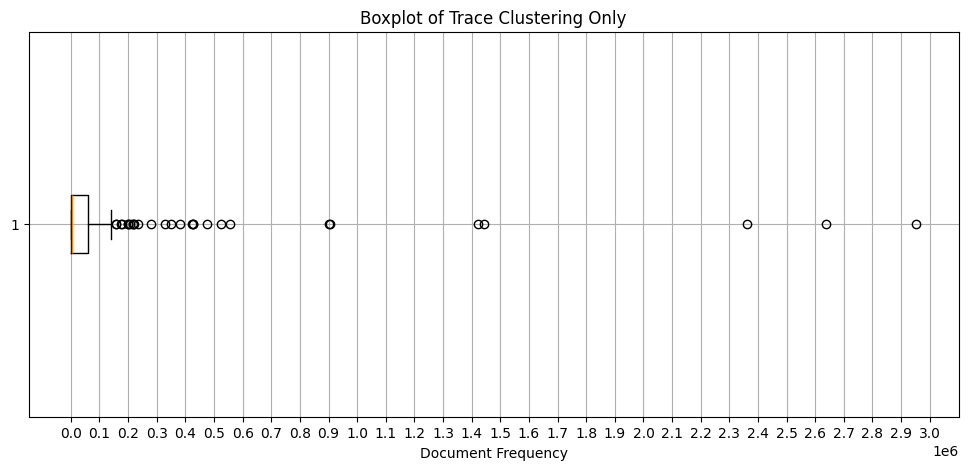

In [19]:
df_counts = np.asarray(X.sum(axis=0)).flatten()

plt.figure(figsize=(12, 5))
plt.boxplot(df_counts, vert=False)
plt.title("Boxplot of Trace Clustering Only")
plt.xlabel("Document Frequency")
plt.grid(True)

max_val = df_counts.max()
tick_interval = 100_000
xticks = np.arange(0, max_val + tick_interval, tick_interval)
plt.xticks(xticks)

plt.show()

In [20]:
# number of ngrams remaining after reducing

# Based on IQR
Q1 = np.percentile(df_counts, 25)
Q3 = np.percentile(df_counts, 75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

idx_iqr = np.where((df_counts >= lower) & (df_counts <= upper))[0]
X_IQR = X[:, idx_iqr]

# Based on Boxplot
idx_500 = np.where(df_counts <= 0.9e6)[0]
X_box = X[:, idx_500]

print(f"Original number of ngrams: {X.shape[1]}")
print(f"Based on IQR: {X_IQR.shape[1]}")
print(f"Based on Box plot: {X_box.shape[1]}")

Original number of ngrams: 189
Based on IQR: 161
Based on Box plot: 182


In [21]:
#Frequency Feature Selection (IQR)

# 1. frequency of ngrams
df_counts = np.asarray(X.sum(axis=0)).flatten()

# 2. IQR 
Q1 = np.percentile(df_counts, 25)
Q3 = np.percentile(df_counts, 75)
IQR = Q3 - Q1

# 3. Lower, Upper IQR
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# 4. Reduce ngrams
valid_idx = np.where((df_counts >= lower) & (df_counts <= upper))[0]

# 5. Filter
X_filtered_iqr = X[:, valid_idx]
X_svd = X_filtered_iqr
#Traces in Cluster 0: 872
#Traces in Cluster 1: 178

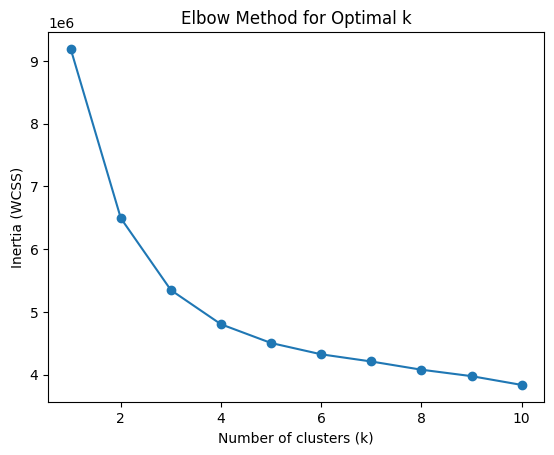

In [22]:
inertia_list = []

for k in range(1, 11):  
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_svd)  
    inertia_list.append(kmeans.inertia_)
    
plt.plot(range(1, 11), inertia_list, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()

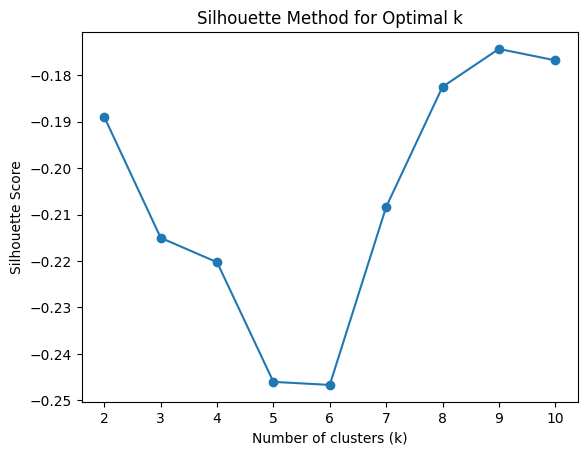

In [23]:
from sklearn.utils import resample

score = []
sample_size = 10000

for i in range(2, 11) :
    km = KMeans(n_clusters = i, random_state = 10)
    km.fit(X_svd)
    pred = km.predict(X_svd)

    if X_svd.shape[0] > sample_size:
        X_sample, labels_sample = resample(X_svd, pred, n_samples=sample_size, random_state=42)
    else:
        X_sample, labels_sample = X_svd, pred  # 샘플 수가 작으면 전체 사용

    sil_score = silhouette_score(X_sample, labels_sample, metric='cosine')
    score.append(sil_score)
    
    #score.append(silhouette_score(X_svd, pred))
    

plt.plot(range(2, 11), score, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()


In [24]:
'''
ngram_ranges = []
for i in range(1, 6):
    for j in range(i, 6):
        ngram_ranges.append((i, j))
trace_texts = trace_mapped_df['activity_str']

fig, axs = plt.subplots(len(ngram_ranges), 2, figsize=(12, 5 * len(ngram_ranges)))
fig.tight_layout(pad=5.0)

for idx, ngram in enumerate(ngram_ranges):
    print(f"\n=== Analyzing ngram_range={ngram} ===")
    
    # Step 1: Vectorization
    vectorizer = CountVectorizer(ngram_range=ngram, token_pattern=r'(?u)\b\w+\b')
    X = vectorizer.fit_transform(trace_texts)

    # Optional: Feature reduction by IQR
    df_counts = np.asarray(X.sum(axis=0)).flatten()
    Q1, Q3 = np.percentile(df_counts, 25), np.percentile(df_counts, 75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    idx_iqr = np.where((df_counts >= lower) & (df_counts <= upper))[0]
    X_filtered = X[:, idx_iqr]
    
    if X_filtered.shape[1] < 2:
        print(f"  Skipping: too few features after filtering: {X_filtered.shape[1]}")
        continue
    
    # Step 2: Elbow Method
    inertia = []
    for k in range(1, 11):
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(X_filtered)
        inertia.append(km.inertia_)
    
    axs[idx, 0].plot(range(1, 11), inertia, marker='o')
    axs[idx, 0].set_title(f'Elbow - ngram_range={ngram}')
    axs[idx, 0].set_xlabel('Number of Clusters (k)')
    axs[idx, 0].set_ylabel('Inertia (WCSS)')
    axs[idx, 0].grid(True)

    # Step 3: Silhouette Score
    score = []
    k_range = []
    for i in range(2, 11) :
        km = KMeans(n_clusters = i, random_state = 10)
        km.fit(X_svd)
        pred = km.predict(X_svd)
    
        if X_svd.shape[0] > sample_size:
            X_sample, labels_sample = resample(X_svd, pred, n_samples=sample_size, random_state=42)
        else:
            X_sample, labels_sample = X_svd, pred  # 샘플 수가 작으면 전체 사용
    
        sil_score = silhouette_score(X_sample, labels_sample, metric='cosine')
        score.append(sil_score)
        k_range.append(i)
        
        #score.append(silhouette_score(X_svd, pred))
    

    axs[idx, 1].plot(k_range, score, marker='o')
    axs[idx, 1].set_title(f'Silhouette - ngram_range={ngram}')
    axs[idx, 1].set_xlabel('Number of Clusters (k)')
    axs[idx, 1].set_ylabel('Silhouette Score')
    axs[idx, 1].grid(True)

plt.tight_layout()
plt.show()
'''

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
C:\Users\melkp\AppData\Local\Temp\ipykernel_1964\1099506289.py:1: SyntaxWarning: invalid escape sequence '\w'
  '''


'\nngram_ranges = []\nfor i in range(1, 6):\n    for j in range(i, 6):\n        ngram_ranges.append((i, j))\ntrace_texts = trace_mapped_df[\'activity_str\']\n\nfig, axs = plt.subplots(len(ngram_ranges), 2, figsize=(12, 5 * len(ngram_ranges)))\nfig.tight_layout(pad=5.0)\n\nfor idx, ngram in enumerate(ngram_ranges):\n    print(f"\n=== Analyzing ngram_range={ngram} ===")\n\n    # Step 1: Vectorization\n    vectorizer = CountVectorizer(ngram_range=ngram, token_pattern=r\'(?u)\x08\\w+\x08\')\n    X = vectorizer.fit_transform(trace_texts)\n\n    # Optional: Feature reduction by IQR\n    df_counts = np.asarray(X.sum(axis=0)).flatten()\n    Q1, Q3 = np.percentile(df_counts, 25), np.percentile(df_counts, 75)\n    IQR = Q3 - Q1\n    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR\n    idx_iqr = np.where((df_counts >= lower) & (df_counts <= upper))[0]\n    X_filtered = X[:, idx_iqr]\n\n    if X_filtered.shape[1] < 2:\n        print(f"  Skipping: too few features after filtering: {X_filtered.shape[1

## Model Training

In [25]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_svd)

trace_mapped_df['cluster'] = kmeans.labels_

In [26]:
trace_mapped_df.head()

,case:concept:name,activity_mapped,activity_str,cluster
0,10000032,"[b, c, d, d, d, d, d, d, d, d, d, d, a, f, f, ...",b c d d d d d d d d d d a f f f f b c e e e a ...,0
1,10000084,"[b, c, a, d, d, d, d, d, d, a, e, a, f, f, b, ...",b c a d d d d d d a e a f f b c a d d d d d d ...,0
2,10000108,"[b, c, a, f, b, c, a, e, e, f, b, c, d, a, e, ...",b c a f b c a e e f b c d a e e a a e a a f,0
3,10000115,"[b, c, a, a, f, f, f, b, a, c, f, f]",b c a a f f f b a c f f,0
4,10000117,"[b, c, a, d, a, f, b, c, a, f, f, f, b, c, a, ...",b c a d a f b c a f f f b c a a a f f,0


In [27]:
cluster_counts = trace_mapped_df['cluster'].value_counts().sort_index()

for cluster_id, count in cluster_counts.items():
    print(f"Traces in Cluster {cluster_id}: {count}")

# n = 2
'''
Traces in Cluster 0: 201271
Traces in Cluster 1: 4195
'''

# n = 9
'''
Traces in Cluster 0: 115393
Traces in Cluster 1: 699
Traces in Cluster 2: 4909
Traces in Cluster 3: 24071
Traces in Cluster 4: 2249
Traces in Cluster 5: 50149
Traces in Cluster 6: 33
Traces in Cluster 7: 174
Traces in Cluster 8: 7789
'''

Traces in Cluster 0: 201271
Traces in Cluster 1: 4195


'\nTraces in Cluster 0: 115393\nTraces in Cluster 1: 699\nTraces in Cluster 2: 4909\nTraces in Cluster 3: 24071\nTraces in Cluster 4: 2249\nTraces in Cluster 5: 50149\nTraces in Cluster 6: 33\nTraces in Cluster 7: 174\nTraces in Cluster 8: 7789\n'

## Process Discovery

C:\Users\melkp\AppData\Roaming\Python\Python312\site-packages\pm4py\objects\log\util\dataframe_utils.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pandas_utils.dataframe_column_string_to_datetime(
C:\Users\melkp\AppData\Roaming\Python\Python312\site-packages\pm4py\objects\log\util\dataframe_utils.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = strpfromiso.fix_dataframe_column(df[col])
C:\Users\melkp\AppData\Roaming\Python\Python312\site-packages\pm4py\objects\log\util\dataf

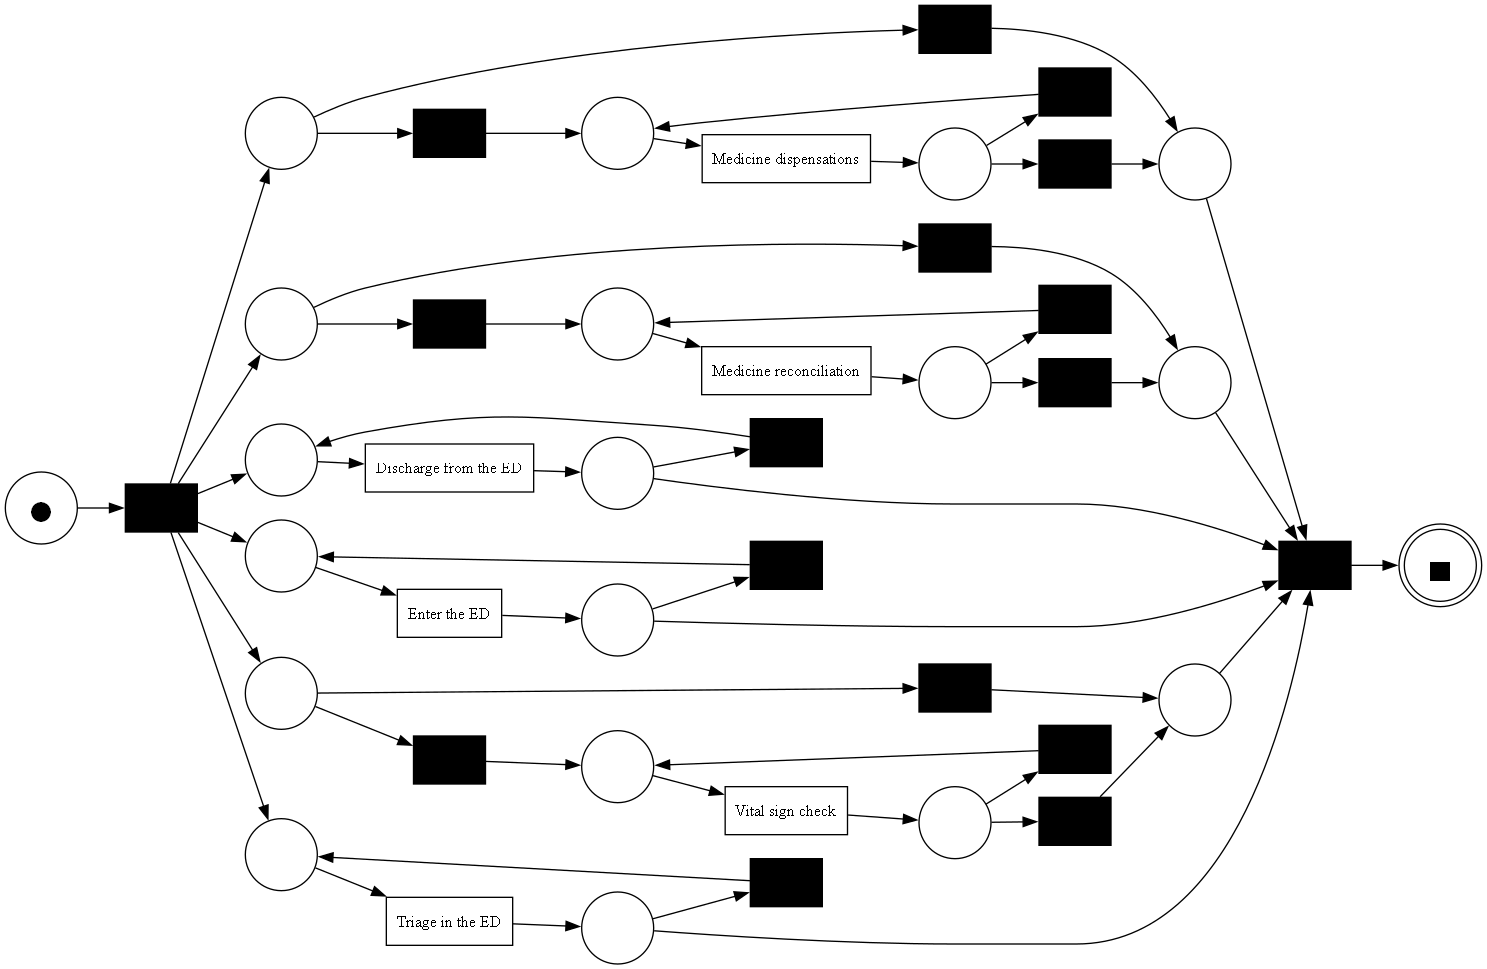

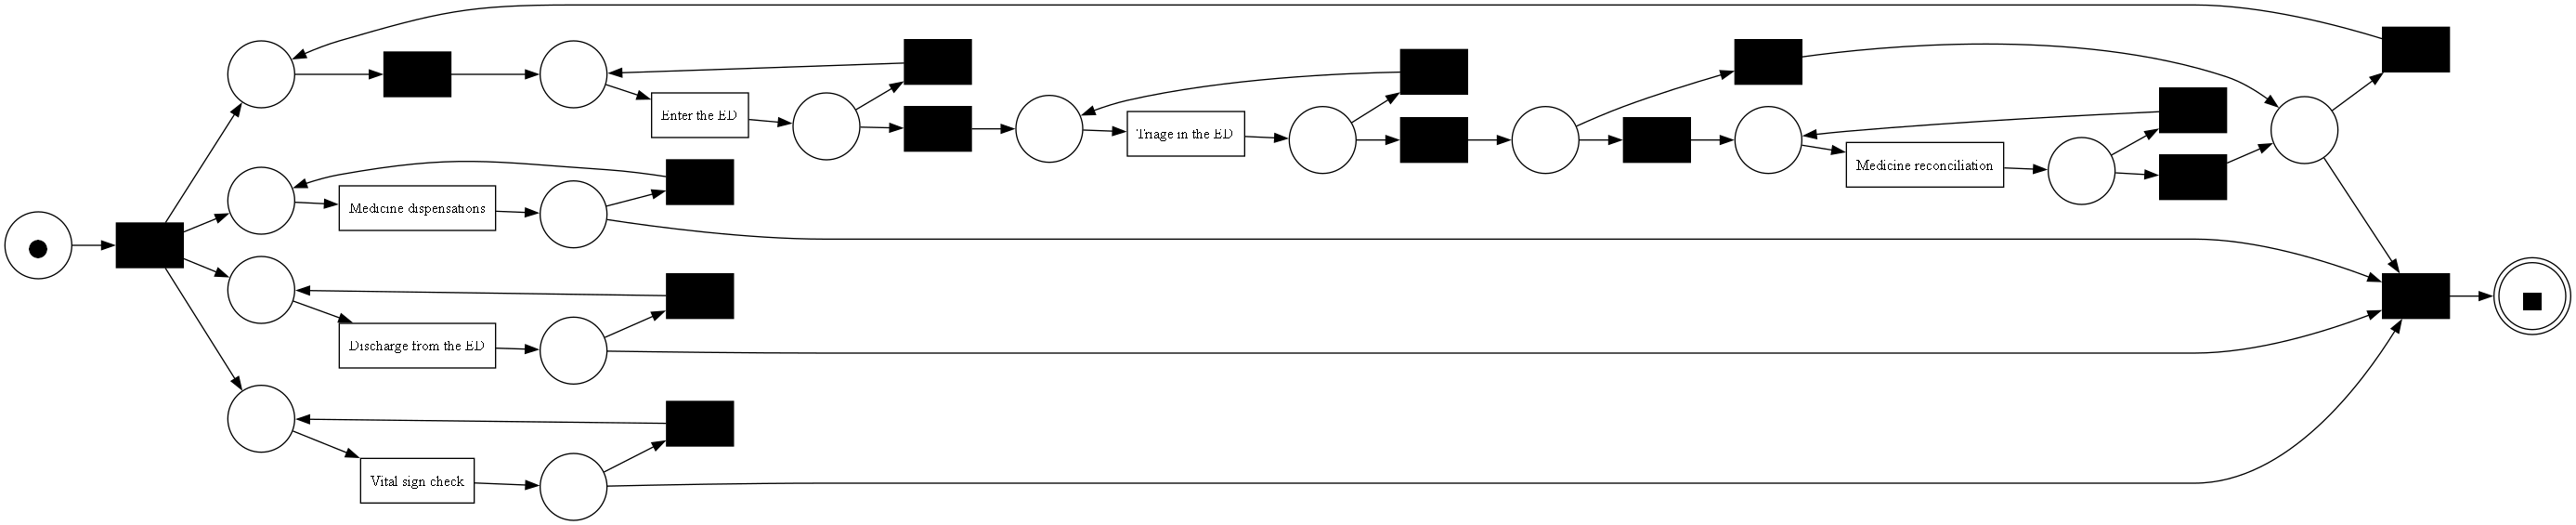

In [28]:
cluster_logs = sg.split_event_log_by_cluster(trace_mapped_df, trace_ordered_df, case_id='case:concept:name')
cluster_models = sg.discover_process_models(cluster_logs)

In [29]:
results_df_tc = sg.evaluate_models_cluster(
    models_dict=cluster_models,
    trace_df=trace_mapped_df,
    full_event_df=trace_ordered_df,
    case_col='case:concept:name',
    time_col='time:timestamp'
)

In [30]:
results_df_tc

,Cluster,# Nodes,# Arcs,CNC,P/T-CD,Cyclomatic Number (CN),ACD,Density,CFC,# Event Classes,# Variants,# Events
0,0,43,56,1.302326,2.617391,14,2.604651,0.031008,6,6,117314,5655384
1,1,38,48,1.263158,2.554622,11,2.526316,0.034139,4,6,4195,1913440
